# Set up


https://docs.quantum.ibm.com/guides/install-qiskit

## Install qiskit

In [60]:
!pip install qiskit[visualization]

~ 10s

In [61]:
import qiskit

qiskit.__version__

'1.2.0'

In [12]:
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


~15s

In [14]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.__version__

'0.29.0'

Better check the version, just in case.
Things change! (and change very fast these days!)

## Set up an IBM Quantum channel

For accessing a IBM's real QC

https://docs.quantum.ibm.com/guides/setup-channel

* Register for IBM id or log in if you already have one:

https://quantum.ibm.com/login

  Recall: IBM id is your registered email.


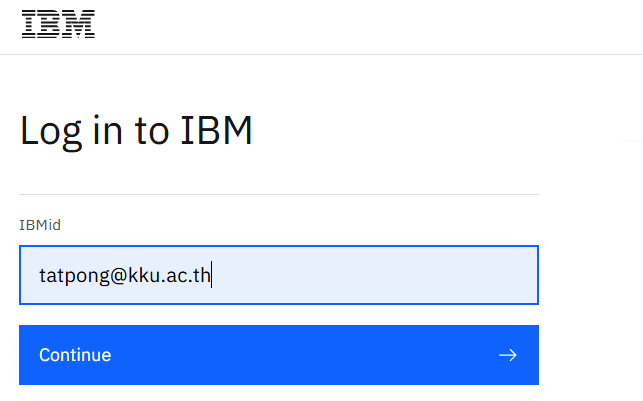

### Get IBM Quantum token

To use IBM's QC, we need a token, ```API Token```.

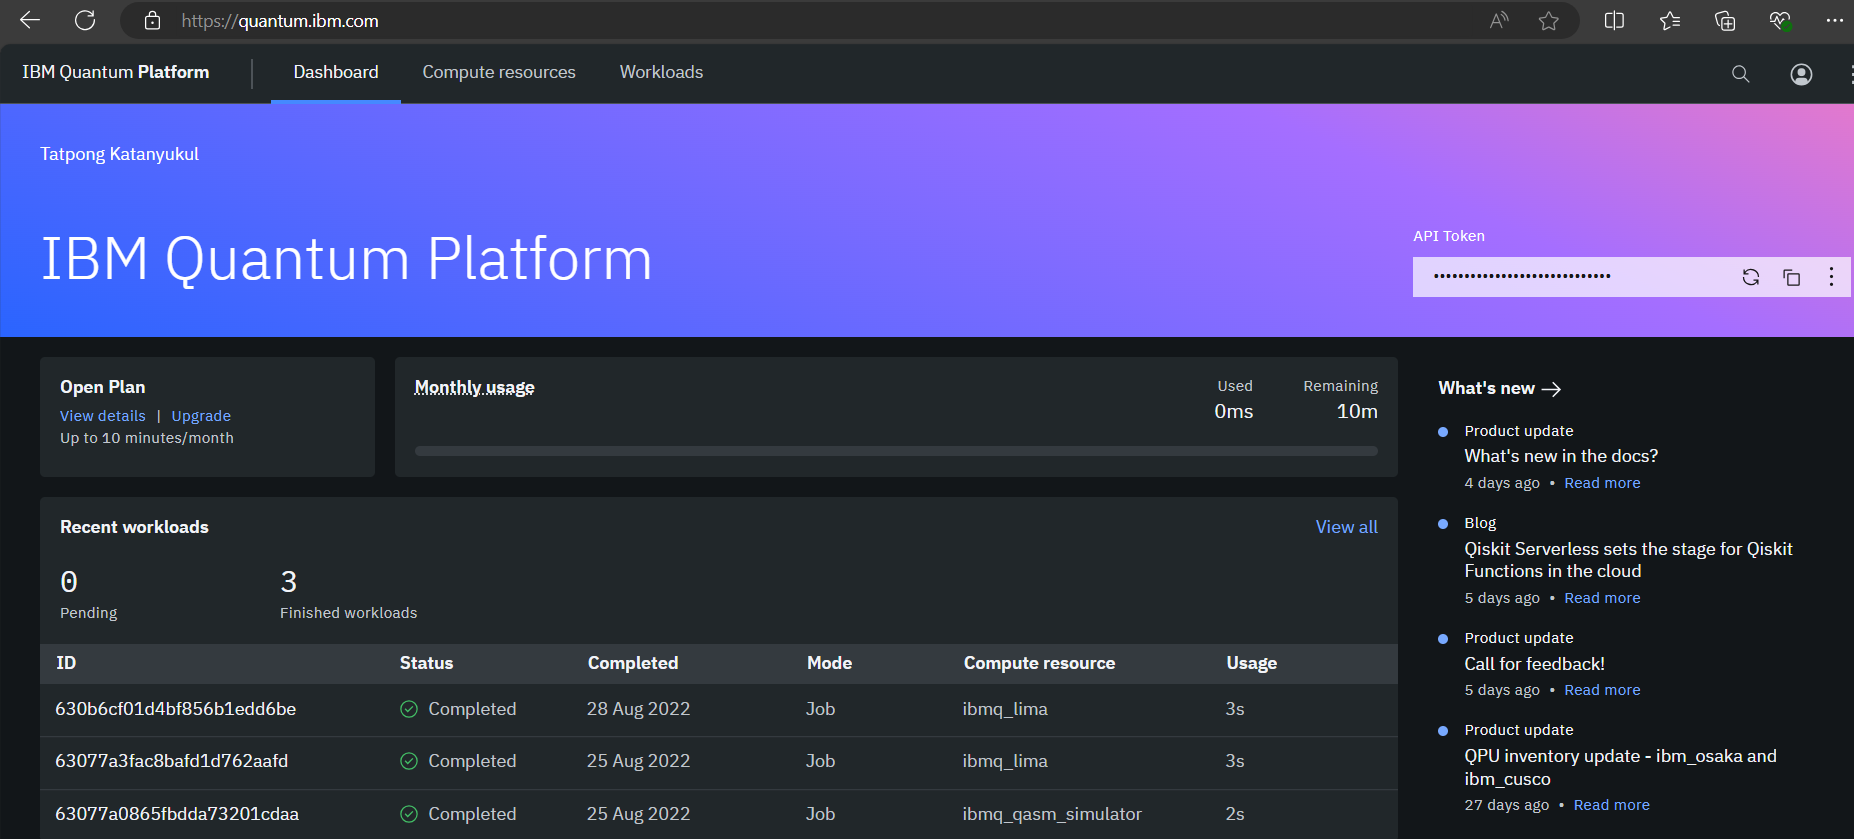

### Authenticate

> Authenticate to the service by calling ```QiskitRuntimeService``` with your IBM Quantum API key and CRN.

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=<Your API Token>)


> Or, optionally use the ```save_account()``` method to save your credentials for easy access later on, before initializing the service.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token=<Your API Token>,
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()

### Test our set up


Test it with simple circuit (aka. Q program).

In [ ]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# Create empty circuit
example_circuit = QuantumCircuit(2)
example_circuit.measure_all()

# We'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

sampler = Sampler(backend)
job = sampler.run([example_circuit])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

job id: cvfzrt3p7drg008m1fz0
PrimitiveResult([PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'version': 2})


# Hello, World!

src: https://docs.quantum.ibm.com/guides/hello-world

## Qiskit patterns

IBM recommended patterns for writing a quantum program:

> 1. Map the problem to a quantum-native format.
>
> 2. Optimize the circuits and operators.
>
> 3. Execute using a quantum primitive function.
>
> 4. Analyze the results.

#### Step 1. Map the problem to a quantum-native format

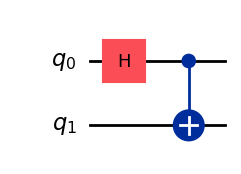

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

Note: this is a quantum "program".

See [QuantumCircuit](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) for all available operations.

When creating quantum circuits, we must also consider what type of data we want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure (```Sampler```), or you can obtain the expectation value of an observable (```Estimator```). Prepare your workload to measure your circuit in one of these two ways with [Qiskit primitives](https://docs.quantum.ibm.com/guides/get-started-with-primitives) (explained in detail in Step 3).

This example measures expectation values by using the ```qiskit.quantum_info``` submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: ```IZ```, ```IX```, ```ZI```, ```XI```, ```ZZ```, and ```XX```.

In [ ]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

> Operator ```ZZ``` is a shorthand for tensor product $Z \otimes Z$, which means measuring Z on qubit 1 and Z on qubit 0 together, and obtaining information about the correlation between qubit 1 and qubit 0.

#### Step 2. Optimize the circuits and operators

> When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture (ISA)](https://docs.quantum.ibm.com/guides/transpile#instruction-set-architecture) and must consider the device's basis gates and qubit connectivity.
>
> The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA.

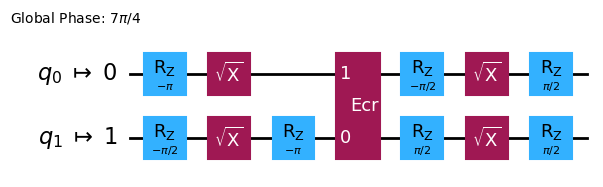

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
# See "Set up an IBM Quantum channel".
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

#### Step 3. Execute using the quantum primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the ```Estimator``` class. ```Estimator``` is one of two [primitives](https://docs.quantum.ibm.com/guides/get-started-with-primitives); the other is ```Sampler```, which can be used to get data from a quantum computer. These objects possess a ```run()``` method that executes the selection of circuits, observables, and parameters (if applicable), using a [primitive unified bloc (PUB)](https://docs.quantum.ibm.com/guides/primitive-input-output#broadcasting-rules).

In [ ]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cvg076cp7drg008m1hq0


After a job is submitted, we can wait until either the job is completed within our current python instance, or use the ```job_id``` to retrieve the data at a later time. (See [the section on retrieving jobs](https://docs.quantum.ibm.com/guides/monitor-job#retrieve-job-results-at-a-later-time) for details.)

After the job completes, examine its output through the job's ```result()``` attribute.

In [ ]:
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

##### Simulator: fake provider

When you run your quantum program on a real device, your workload must wait in a queue before it runs. To save time, you can instead use the following code to run this small workload on the [fake_provider](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/fake_provider) with the Qiskit Runtime local testing mode. Note that this is only possible for a small circuit. When you scale up in the next section, you will need to use a real device.

In [ ]:

# Use the following code instead if you want to run on a simulator:

from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
estimator = Estimator(backend)

# Convert to an ISA circuit and layout-mapped observables.

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()

# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).

job_result = job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.

pub_result = job.result()[0]

In [ ]:
pub_result

PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})

#### Step 4. Analyze the results

> The analyze step is typically where we might postprocess our results using, for example, measurement error mitigation or zero noise extrapolation (ZNE). We might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to our problem. For this example, plot each of the expectation values that were measured for our circuit.

The expectation values and standard deviations for the observables you specified to Estimator are accessed through the job result's ```PubResult.data.evs``` and ```PubResult.data.stds``` attributes. To obtain the results from ```Sampler```, use the ```PubResult.data.meas.get_counts()``` function, which will return a ```dict``` of measurements in the form of bitstrings as keys and counts as their corresponding values. For more information, see [Get started with Sampler](https://docs.quantum.ibm.com/guides/get-started-with-primitives#get-started-with-sampler).

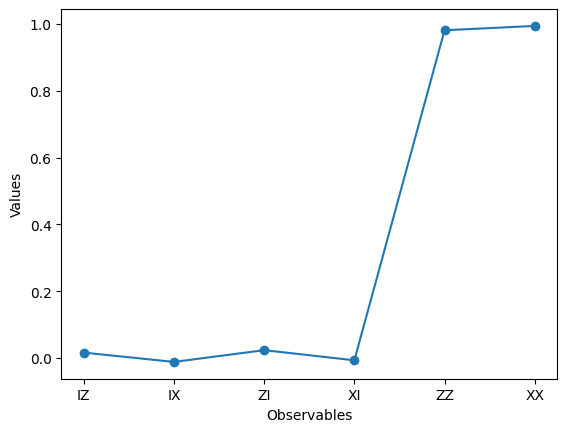

In [ ]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (```XX``` and ```ZZ```) are 1. This is a hallmark of quantum entanglement.

## Sampler

src: https://docs.quantum.ibm.com/guides/get-started-with-primitives#get-started-with-sampler

### 1. Initialize the account

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

### 2. Create a circuit

In [ ]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import random_hermitian

n_qubits = 127

mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
circuit.measure_all()

Use the transpiler to get an ISA circuit.


In [ ]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(circuit)

In [ ]:
# isa_circuit.draw('mpl', idle_wires=False)
# Too long to run

### 3. Initialize the Qiskit Runtime Sampler

When you initialize the Sampler, use the ```mode``` parameter to specify the mode you want it to run in. Possible values are ```batch```, ```session```, or ```backend``` objects for batch, session, and job execution mode, respectively. For more information, see [Introduction to Qiskit Runtime execution modes](https://docs.quantum.ibm.com/guides/execution-modes).

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)

### 4. Invoke the Sampler and get results



Next, invoke the ```run()``` method to generate the output. The circuit and optional parameter value sets are input as _primitive unified bloc_ (PUB) tuples.

In [ ]:
job = sampler.run([isa_circuit])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cvg19m68w2g0008ehyk0
>>> Job Status: QUEUED


In [ ]:
job.status()

'QUEUED'

If it is queued, check it out later.

We can do it at
[IBM Quantum Platform](https://quantum.ibm.com)

Check out the job

E.g.,

https://quantum.ibm.com/jobs/cvg19m68w2g0008ehyk0

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=<Your API Token>
)
job = service.job('cvg19m68w2g0008ehyk0')
job_result = job.result()

# To get counts for a particular pub result, use
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register.
# You can use circuit.cregs to find the name of the classical registers.

In [17]:
result = job.result()

# Get results for the first (and only) PUB
pub_result = result[0]
print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

Counts for the meas output register: {'0101000001100000010010101001001001010111101000001000001010001110000100000101000100001111000000010000000010000010000000110000000': 1, '1011001111001000011011110100101010001001110010110011011001001011100000000001000000010011100000000001010000010000100000100010000': 1, '0000000000000000110101111011011001000010111010011111000010001100000000000100100000001010101000000101001000010010100001100110000': 1, '0100000010000010000011111011011001000001111001000011101010110001000000000100000100011111101000100101001010000000100001000000000': 1, '1000011010111111001111111000001110010000110110001010000111011100100000100000000000000011000000000101001010010010000000010100000': 1, '1111011100001001111010111000011100010000011010101010010110111010000000000100100000010011000000000001000010000010000001110010000': 1, '1001111001100110000011001001100110000100000110110010010011111011100000000100000000001010001000100000000010000010000001010010000': 1, '00000100111010100010111

# AerSimulator

https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html

In [18]:
!pip install qiskit-aer

In [19]:
import qiskit_aer

qiskit_aer.__version__

'0.15.0'

## Example

In [20]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

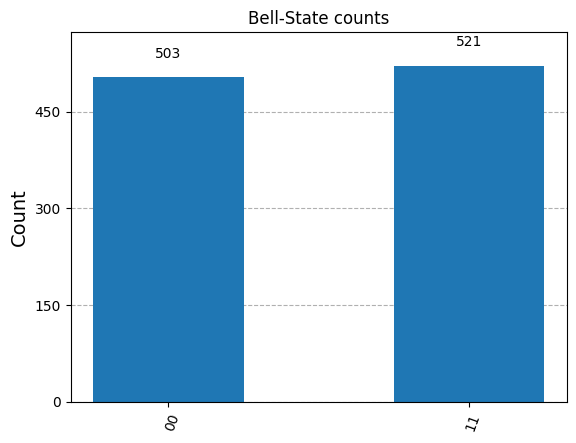

In [21]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = AerSimulator()
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

# Quantum search

2024 Sep 10th


Try Glover based on
[Grovers Algorithm — Programming on Quantum Computers — Coding with Qiskit S2E3](https://www.youtube.com/watch?v=0RPFWZj7Jm0)

This notebook is adapted based on Lab 3 of Introduction to Quantum Computing 2 (U Chicago on EdX)

## The problem: unstructured search

Check out qiskit document:

https://docs.quantum.ibm.com/api/qiskit/release-notes/1.2

In [22]:
my_list = [1, 3, 5, 2, 4, 9, 5, 8, 0, 7, 6]

In [23]:
# This is a kind of a black box.

def the_oracle(my_input):
  winner = 7
  if my_input is winner:
    response = True
  else:
    response = False

  return response

In [24]:
# Classical search

for index, trial_number in enumerate(my_list):
  if the_oracle(trial_number) is True:
    print('Winner is found @ %d'%index)
    print(f'* It is {my_list[index]}.')
    print('We spent %d calls to the oracle for %d items.'%(index + 1, len(my_list)))
    break

Winner is found @ 9
* It is 7.
We spent 10 calls to the oracle for 11 items.


The number of calls may be vary depending on where the answer is.
On average we will spend around $n/2$ times.

In the worst case, we will spend $n$ times.

Anyhow, it is $O(n)$ for the classical.

## Grover

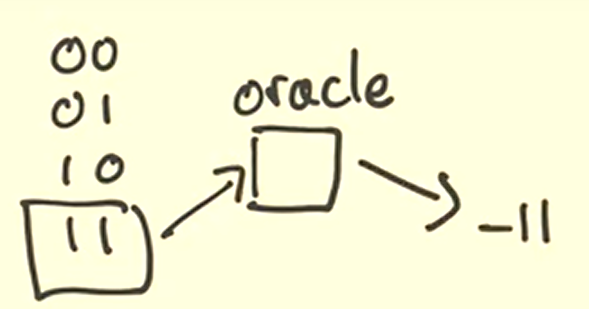

Suppose we have 2 qubits and the answer is ```11```,
the output from the oracle is ```-11``` for input ```11```
otherwise the output is the same as its input.

To implement this oracle,
we need a controlled-Z gate:

$$|11\rangle \rightarrow [CZ] \rightarrow -|11\rangle$$

We also need

* Amplitude amplification.
  * Glover's diffusion operator
    

In [25]:
# Glover

from qiskit import *
from matplotlib import pyplot as plt
import numpy as np

In [26]:
# Define the oracle.
# Let's do 2 qubits.

oracle = QuantumCircuit(2, name='oracle')
oracle.cz(0,1)
oracle.to_gate() # Make a gate named 'oracle'
oracle.draw()

q_0: ─■─
      │ 
q_1: ─■─

### Check the oracle

Test if the oracle works as expected.

In [27]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle,[0,1])
grover_circ.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│  oracle │
q_1: ┤ H ├┤1        ├
     └───┘└─────────┘
c: 2/════════════════

#### Run it on AerSimulator

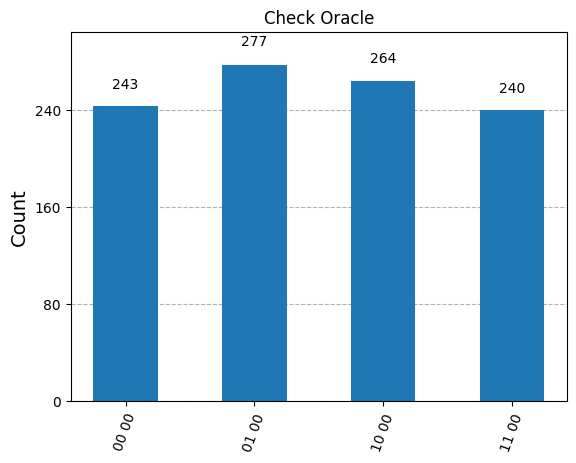

In [29]:
# Configure backend
from qiskit_aer import AerSimulator

grover_circ.measure_all()

# Transpile for simulator
simulator = AerSimulator()
grover_circ = transpile(grover_circ, simulator)

# Run and get counts
result = simulator.run(grover_circ).result()
counts = result.get_counts(grover_circ)
plot_histogram(counts, title='Check Oracle')

We need to check the state vector, otherwise we cannot see the phase flip (negative sign).

In [34]:
import qiskit_aer

In [36]:
dir(qiskit_aer)[:10]

['Aer',
 'AerError',
 'AerJob',
 'AerProvider',
 'AerSimulator',
 'QasmSimulator',
 'StatevectorSimulator',
 'UnitarySimulator',
 '__builtins__',
 '__cached__']

In [37]:
from qiskit_aer import StatevectorSimulator

grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle,[0,1])

# Transpile for simulator
simulator = StatevectorSimulator()
grover_circ = transpile(grover_circ, simulator)

# Run and get counts
result = simulator.run(grover_circ).result()


# Get state vectors
sv = result.get_statevector()

np.around(sv, 2)

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

Yes! The last state (```11```) has its sign flip.

That is

$$| \psi \rangle = 0.5|00\rangle + 0.5|01\rangle + 0.5|10\rangle - 0.5|11\rangle . $$

Good!

But, we cannot measure this $-0.5$ of _probability amplitude_.

The probability or more specifically count in our measurement cannot see this negative sign!

The count will correspond to probability, which is a square of the magnitude of _probability amplitude_.

I.e.,

* Pr['00'] = $|0.5|^2$ = 0.25
* Pr['01'] = $|0.5|^2$ = 0.25
* Pr['10'] = $|0.5|^2$ = 0.25
* Pr['11'] = $|-0.5|^2$ = 0.25

Note $|a + jb|^2 = (a + j b)(a - jb) = a^2 + b^2$



More precisely,
probability of state $| x \rangle$,

$$P[x] = \langle x | c^\ast c | x \rangle = | c |^2$$

Hence, we need reflection operation to selectively "amplify" the amplitude of the answer.

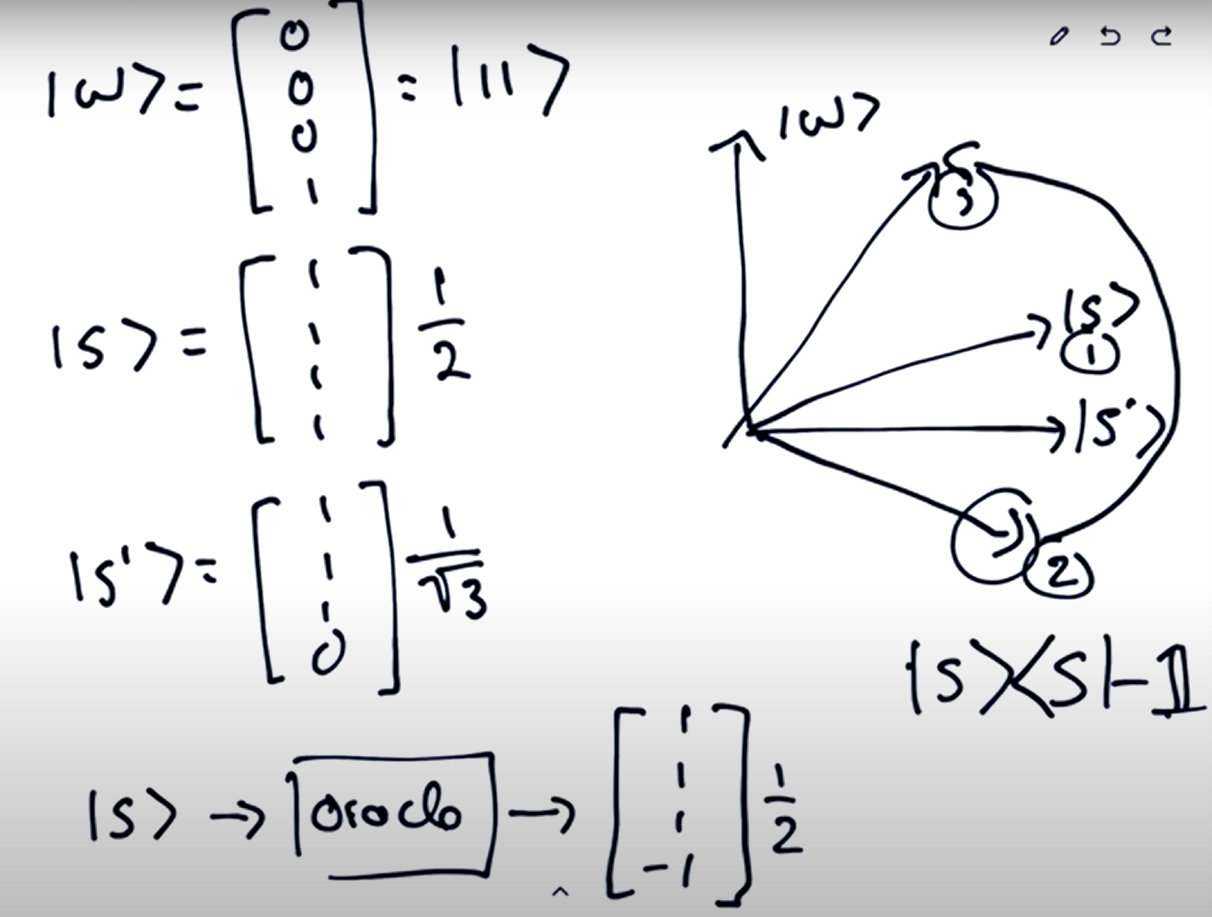

### Reflection

Reflection operator is to apply a negative phase to every state orthogonal to our input state.

In [39]:
# Reflection
reflection = QuantumCircuit(2, name='reflection')
reflection.h([0,1]) # To bring back our original |00> state
reflection.z([0,1])
reflection.cz(0,1)
reflection.h([0,1]) # Transform it back
reflection.to_gate()

reflection.draw()

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

### Put them all together

In [40]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle, [0,1])
grover_circ.append(reflection, [0,1])
grover_circ.measure([0,1], [0,1])

grover_circ.draw()

┌───┐┌─────────┐┌─────────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0            ├┤M├───
     ├───┤│  oracle ││  reflection │└╥┘┌─┐
q_1: ┤ H ├┤1        ├┤1            ├─╫─┤M├
     └───┘└─────────┘└─────────────┘ ║ └╥┘
c: 2/════════════════════════════════╩══╩═
                                     0  1

#### Try it with AerSimulator

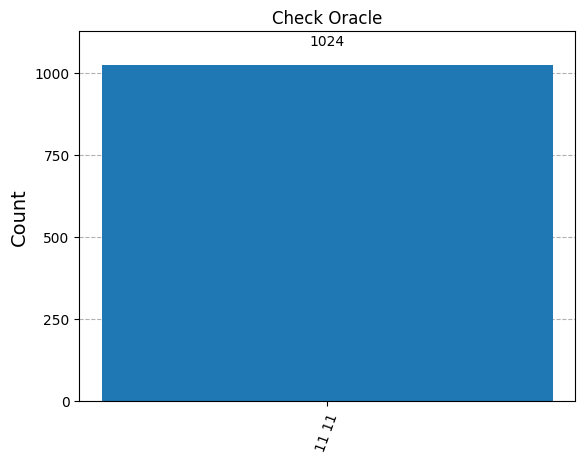

In [41]:
# Configure backend
from qiskit_aer import AerSimulator

grover_circ.measure_all()

# Transpile for simulator
simulator = AerSimulator()
grover_circ = transpile(grover_circ, simulator)

# Run and get counts
result = simulator.run(grover_circ).result()
counts = result.get_counts(grover_circ)
plot_histogram(counts, title='Check Oracle')

# Grover on real QC

## 1. Map the problem

In [62]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle, [0,1])
grover_circ.append(reflection, [0,1])
grover_circ.measure([0,1], [0,1])

grover_circ.draw()

┌───┐┌─────────┐┌─────────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0            ├┤M├───
     ├───┤│  oracle ││  reflection │└╥┘┌─┐
q_1: ┤ H ├┤1        ├┤1            ├─╫─┤M├
     └───┘└─────────┘└─────────────┘ ║ └╥┘
c: 2/════════════════════════════════╩══╩═
                                     0  1

## 2. Optimize the circuit

In [46]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(grover_circ)

## 3. Execute

### Configure the backend

In [44]:
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(channel="ibm_quantum", token=<Your API Token>)

backend = service.least_busy(operational=True, simulator=False)

In [47]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)

In [48]:
job = sampler.run([isa_circuit])

In [49]:
job.status()

'QUEUED'

In [50]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cvg2p0rw5350008x6ze0
>>> Job Status: QUEUED


### Wait for our turn

Check out [IBM Quantum Platform](https://quantum.ibm.com)


## Analyze result

In [51]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=<Your API Token>
)
job = service.job('cvg2p0rw5350008x6ze0')
job_result = job.result()

# To get counts for a particular pub result, use
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register.
# You can use circuit.cregs to find the name of the classical registers.

In [72]:
job_result[0].data.c.get_counts()

{'11': 3843, '01': 201, '10': 44, '00': 8}

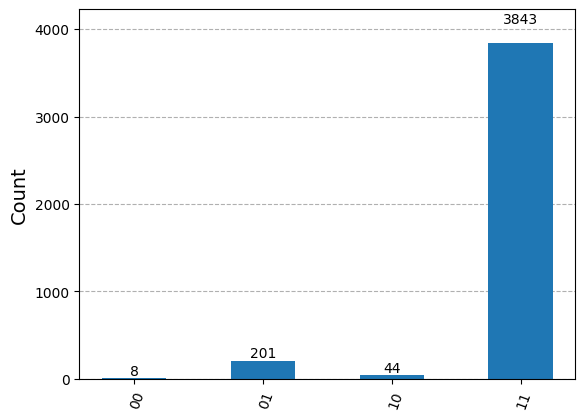

In [75]:
plot_histogram(job_result[0].data.c.get_counts())

# Try Grover again with different answer

We will use simulator for simplicity.

## Set the oracle

In [92]:
from qiskit import *

# Make the oracle
oracle = QuantumCircuit(2, name='oracle')

# 00
# oracle.x(0)
# oracle.x(1)
# oracle.cz(0,1)
# oracle.x(0)
# oracle.x(1)

# 01
oracle.x(1)
oracle.cz(0,1)
oracle.x(1)

# 10
# oracle.x(0)
# oracle.cz(0,1)
# oracle.x(0)

# 11
# oracle.cz(0,1)

oracle.to_gate() # Make a gate named 'oracle'


Instruction(name='oracle', num_qubits=2, num_clbits=0, params=[])

## Test the oracle

In [93]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle,[0,1])
grover_circ.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│  oracle │
q_1: ┤ H ├┤1        ├
     └───┘└─────────┘
c: 2/════════════════

In [94]:
from qiskit_aer import StatevectorSimulator

grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle,[0,1])

# Transpile for simulator
simulator = StatevectorSimulator()
grover_circ = transpile(grover_circ, simulator)

# Run and get counts
result = simulator.run(grover_circ).result()


# Get state vectors
sv = result.get_statevector()

np.around(sv, 2)

array([ 0.5+0.j, -0.5+0.j,  0.5+0.j,  0.5+0.j])

## Make reflection operator

In [95]:
# Reflection
reflection = QuantumCircuit(2, name='reflection')
reflection.h([0,1]) # To bring back our original |00> state
reflection.z([0,1])
reflection.cz(0,1)
reflection.h([0,1]) # Transform it back
reflection.to_gate()


Instruction(name='reflection', num_qubits=2, num_clbits=0, params=[])

## Map Grover search

In [96]:
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle, [0,1])
grover_circ.append(reflection, [0,1])
grover_circ.measure([0,1], [0,1])

grover_circ.draw()

┌───┐┌─────────┐┌─────────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0            ├┤M├───
     ├───┤│  oracle ││  reflection │└╥┘┌─┐
q_1: ┤ H ├┤1        ├┤1            ├─╫─┤M├
     └───┘└─────────┘└─────────────┘ ║ └╥┘
c: 2/════════════════════════════════╩══╩═
                                     0  1

## Execute

In [97]:
# Configure backend
from qiskit_aer import AerSimulator

grover_circ.measure_all()

# Transpile for simulator
simulator = AerSimulator()
grover_circ = transpile(grover_circ, simulator)

# Run
result = simulator.run(grover_circ).result()

## Get result

{'01 01': 1024}


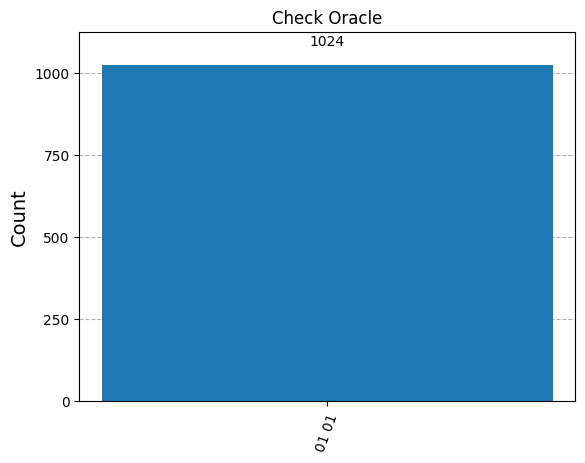

In [98]:
counts = result.get_counts(grover_circ)
print(counts)
plot_histogram(counts, title='Check Oracle')